In [1]:
#  Load the "autoreload" extension so that code can change
%load_ext autoreload
%reload_ext autoreload
from pathlib import Path

#  always reload modules so that as you change code in src, it gets loaded
%autoreload 2
%matplotlib inline

import sys
sys.path.append('../')
from src.imports import *
from src.data.download_data import *
from src.data.fire_data import *
from src.data.read_data import *
from src.gen_functions import *
from src.features.dataset import Dataset
from src.features.build_features import *
from src.models.train_model import *
from src.visualization.vis_data import *
import seaborn as sns
output_notebook()
plt.rcParams.update({'font.size': 14})

Loading BokehJS ...

# Setup the Dataset

In [3]:
# start building dataset from scratch. Only have to do this once after adding more data
dataset = Dataset('Jakarta')
dataset.build_all_data( build_fire=True, build_holiday = True)

Averaging data from 4 stations
Loading all hotspots data. This might take sometimes
before drop (1075000, 18)
after drop (1046319, 10)


In [2]:
# reinit the data and load saved process data 
dataset = Dataset('Jakarta')
dataset.load_()
# merge pollution data with other data except fire
dataset.feature_no_fire()

data no fire has shape (32185, 13)


In [21]:
# pollution data is in attribute 
dataset.poll_df.head(2)

,PM2.5
datetime,
2015-12-21 23:00:00,22.0
2015-12-22 00:00:00,24.0


In [22]:
# fire data is in attribute fire
dataset.fire.head(2)

,latitude,longitude,confidence,lat_km,long_km,distance,power,count
datetime,,,,,,,,
2002-07-04 05:04:00,-8.1127,112.9357,27,-900,12572,710.073940,217.280,1
2002-07-04 05:04:00,-8.1091,112.9136,73,-900,12569,707.210011,366.912,1


In [23]:
# weather data is in attribute 
dataset.wea.head(2)

,Time,Temperature(C),Humidity(%),Wind,Wind Speed(kmph),Pressure(in),Precip.(in),Condition
datetime,,,,,,,,
2000-01-01 01:00:00,07:00 AM,25.0,94.0,SW,6.0,29.79577,0.0,Clouds
2000-01-01 01:30:00,07:00 AM,25.0,94.0,SW,6.0,29.79577,0.0,Clouds


In [24]:
# merge pollution data and weather is in 
dataset.data_no_fire.head(2)

,PM2.5,Temperature(C),Humidity(%),Wind Speed(kmph),wind_E,wind_N,wind_S,wind_W,is_rain,is_holiday,is_weekend,day_of_week,time_of_day
datetime,,,,,,,,,,,,,
2015-12-21 23:00:00,22.0,26.0,76.0,11.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,23.0
2015-12-22 00:00:00,23.0,26.0,79.0,8.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0


# Explore the Data

Index(['PM2.5'], dtype='object')


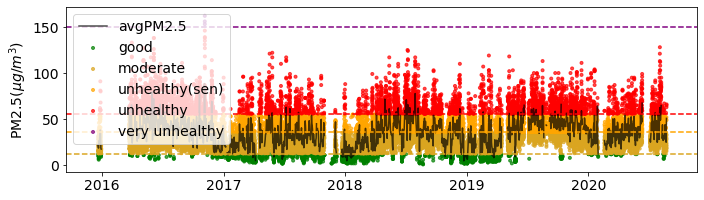

In [3]:
# plot the raw data
plot_all_pollutions(dataset.poll_df, city_name=dataset.city_name)

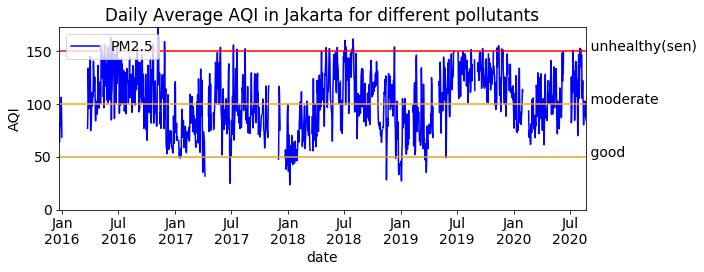

In [4]:
plot_polls_aqi(dataset.poll_df.copy(), dataset.roll_dict, dataset.city_name, filename=dataset.report_folder + 'all_pol_aqi.png' )

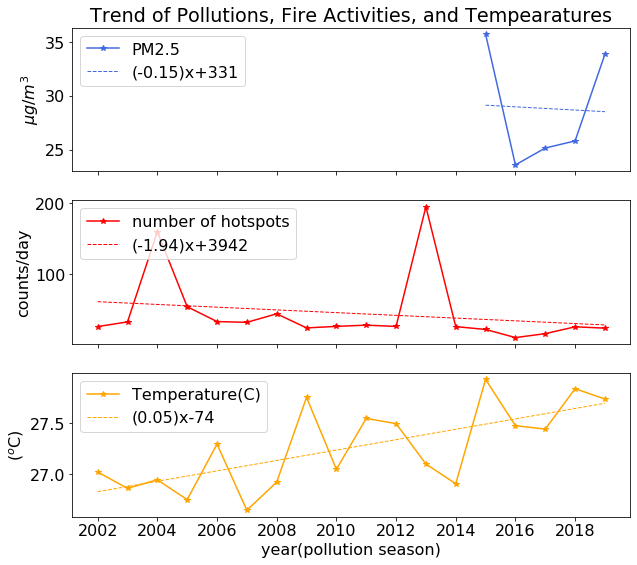

In [74]:
ax, year_avg = plot_yearly_ln(dataset, filename=dataset.report_folder + 'compare_ln_trends.png')

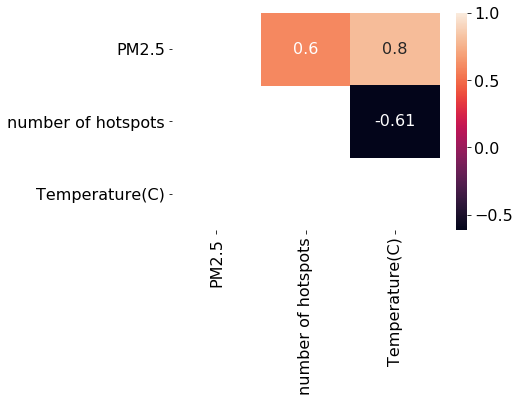

In [75]:
plot_corr(year_avg, figsize=(6,4))

aqi 100 in  06-30 to 06-29
aqi 150 in  07-19 to 07-19


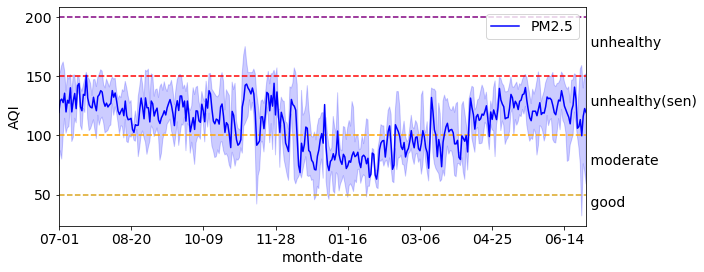

In [5]:
plot_season_aqi(dataset.poll_df.copy(), dataset.roll_dict, 'PM2.5', filename=dataset.report_folder + 'seasonal_pattern_PM25.png')

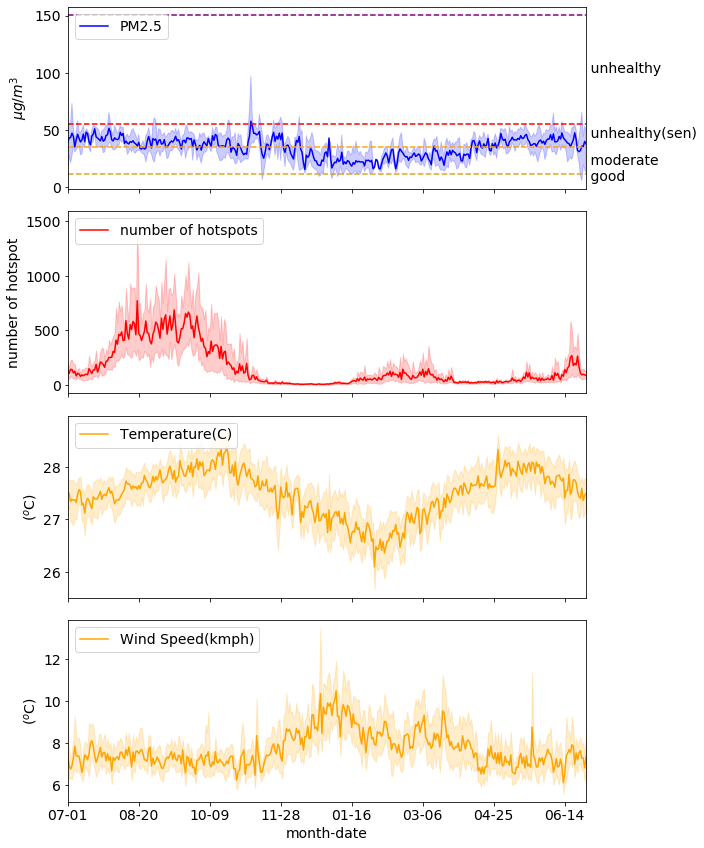

In [6]:
compare_seson_avg(dataset, agg='mean', filename=dataset.report_folder + 'fire_PM25_season.png')

In [81]:
dataset.poll_df['PM2.5'].dropna().head()

datetime
2015-12-21 23:00:00    22.0
2015-12-22 00:00:00    24.0
2015-12-22 03:00:00    28.0
2015-12-22 04:00:00    15.0
2015-12-22 05:00:00    15.0
Name: PM2.5, dtype: float64